In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [18]:
# valid columns when high speed
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150')
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision', 'RiskFactor', 'TimeHeadway')
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision')
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision', 'RiskFactor')
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision', 'PathType')

In [4]:
printf <- function(...) cat(sprintf(...))

In [21]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.024)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {            
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [6]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [7]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [8]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Red

In [9]:
df3 <- read.csv("../data/middle/sp3.csv", stringsAsFactors=FALSE)

In [10]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [11]:
allFeatures <- c(colnames(df3))
expr <- createFormula(invalids, allFeatures)

In [24]:
result <- CV(df3, expr, verbose=TRUE)
printRedRatios(df3)
printf("Red: Mean correct/predict = %f\n", result[2])
printf("Blue: Mean correct/predict = %f\n", result[3])
printf("CV value: %f", result[1])

Fold1
As for Red: correct/predict = 35/55 = 0.636364
As for Blue: correct/predict = 25/49 = 0.510204

Fold2
As for Red: correct/predict = 46/68 = 0.676471
As for Blue: correct/predict = 23/36 = 0.638889

Fold3
As for Red: correct/predict = 47/80 = 0.587500
As for Blue: correct/predict = 11/23 = 0.478261

Fold4
As for Red: correct/predict = 46/78 = 0.589744
As for Blue: correct/predict = 13/27 = 0.481481

Fold5
As for Red: correct/predict = 41/68 = 0.602941
As for Blue: correct/predict = 18/36 = 0.500000

Fold6
As for Red: correct/predict = 52/84 = 0.619048
As for Blue: correct/predict = 13/20 = 0.650000

Fold7
As for Red: correct/predict = 48/85 = 0.564706
As for Blue: correct/predict = 8/20 = 0.400000

Fold8
As for Red: correct/predict = 46/76 = 0.605263
As for Blue: correct/predict = 15/29 = 0.517241

Fold9
As for Red: correct/predict = 45/72 = 0.625000
As for Blue: correct/predict = 18/32 = 0.562500

Fold10
As for Red: correct/predict = 34/57 = 0.596491
As for Blue: correct/predict 

In [13]:
fit3 <- rpart(expr, data=df3, method="class")

In [14]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01

In [15]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
[1] AheadDistance   AverageVelocity Curve           CurveAverage   
[5] DistManBicycle  DistSignal      Engine          Pitch          
[9] Speed          

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.025241      0   1.00000 1.00000 0.035602
2 0.013363      6   0.79733 0.98886 0.035552
3 0.011136     18   0.63474 0.98441 0.035531
4 0.010000     20   0.61247 0.95768 0.035394


In [16]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.02524128      0 1.0000000 1.0000000 0.03560167
2 0.01336303      6 0.7973274 0.9888641 0.03555182
3 0.01113586     18 0.6347439 0.9844098 0.03553093
4 0.01000000     20 0.6124722 0.9576837 0.03539401

Variable importance
            Speed     AheadDistance   AverageVelocity      CurveAverage 
               20                13                10                10 
           Engine             Curve          RoadType             Pitch 
               10                 9                 8                 6 
    SteeringAngle        DistSignal    DistManBicycle   ManBicycleCount 
                3                 2                 2                 2 
AccelerationSpeed        ManBicycle         LaneCount 
                2                 1                 1 

Node number 1: 1042 observations,    complexity param=0.02524128
  predicted class=Red   expected loss=0.

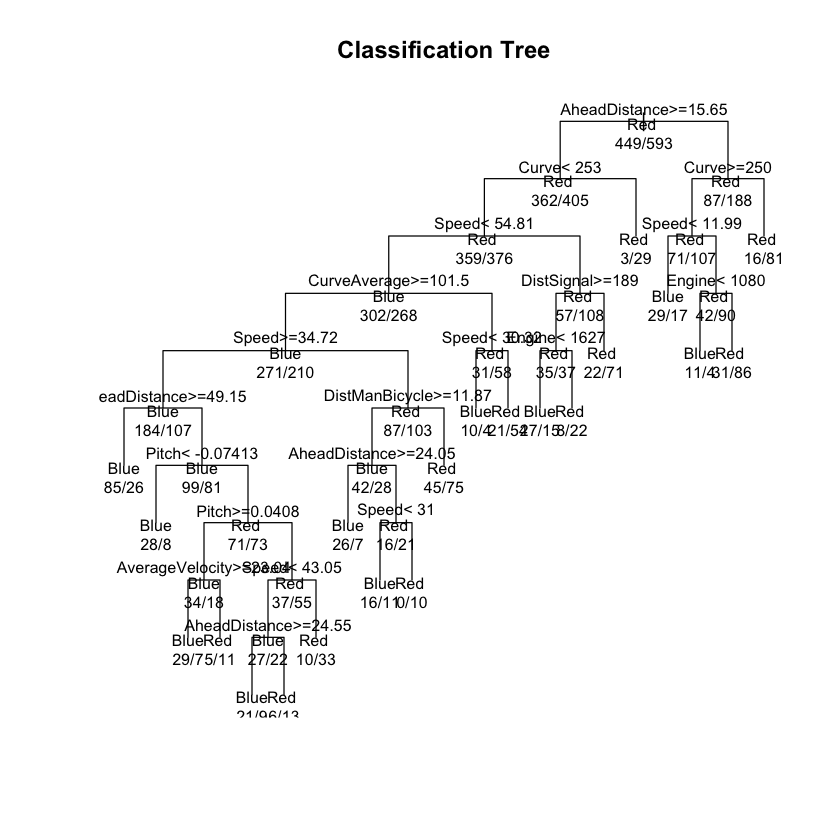

In [17]:
plot(fit3, uniform=TRUE, main="Classification Tree")
text(fit3, use.n=TRUE, all=TRUE, cex=.8)